# Логистическая и линейная регрессия

# Классификация

Первые 5 строк и размер датасета

In [29]:
import pandas as pd
import numpy as np
import sklearn as sk
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
# df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
#                                   "tan5577/heart-failure-dataset/versions/1",
#                                   "heart.csv")
df = pd.read_csv("heart.csv")

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Обработка категориальных и числовых признаков

In [31]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
binary_features = ['Sex', 'FastingBP', 'ExerciseAngina']
categorical_features = ['ChestPainType', 'RestingECG', 'ST_Slope']

df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

df['Cholesterol'] = df['Cholesterol'].replace(0, df['Cholesterol'].median())
df['RestingBP'] = df['RestingBP'].replace(0, df['RestingBP'].median())

Функция для матрицы ошибок.

In [32]:
def conf_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

Создание препроцессора

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

Запуск модели от sklearn на обычном бейзлайне без улучшений.

Бейзлайн LogisticRegression:
Accuracy: 0.8859
ROC-AUC:  0.9303
F1-score: 0.8986
Recall:   0.9118


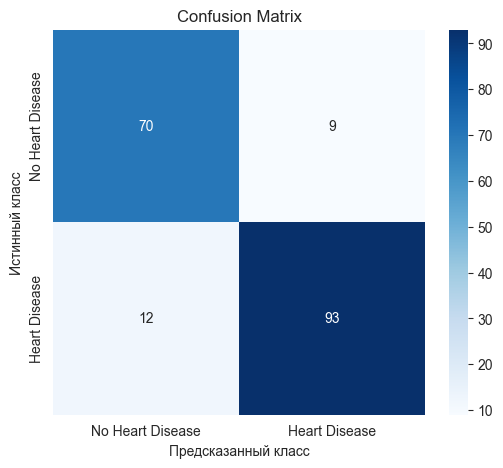

In [34]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

logistic_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

logistic_baseline.fit(X_train, y_train)
y_pred = logistic_baseline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, logistic_baseline.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Бейзлайн LogisticRegression:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall:   {recall:.4f}")

conf_matrix(y_test, y_pred)

Подберем оптимальные параметры.
Основной параметр - C: он отвечает за силу регуляризации. Чем больше C, тем меньше регуляризация (может лучше подстроиться под данные, но рискует переобучиться). Чем меньше C, тем сильнее модель "прижимается" к простым решениям - это помогает, если данных мало или много шума. \
Есть также разные алгоритмы оптимизации (solver): \
liblinear - надёжный, особенно при небольшом объёме данных, \
lbfgs и sag - быстрее на больших данных, но требуют больше памяти. \
Регуляризация L2 — она просто уменьшает веса, но не обнуляет их, это хорошо, когда все признаки потенциально полезны (как в медицинской задаче). К тому же с L1 не все алгоритмы оптимизации.

In [35]:
logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'classifier__C': np.arange(0.1, 20, 0.2),
    'classifier__solver': ['liblinear', 'lbfgs', 'sag'],
    'classifier__penalty': ['l2']
}

grid_search = GridSearchCV(
    logistic, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (CV):", grid_search.best_score_)

best_params = grid_search.best_params_

Лучшие параметры: {'classifier__C': np.float64(1.1000000000000003), 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Лучший ROC-AUC (CV): 0.9154147969866127


Запустим на тестовых данных

Улучшенный LogisticRegression:
Accuracy: 0.8859
ROC-AUC:  0.9305
F1-score: 0.8986
Recall:   0.9118


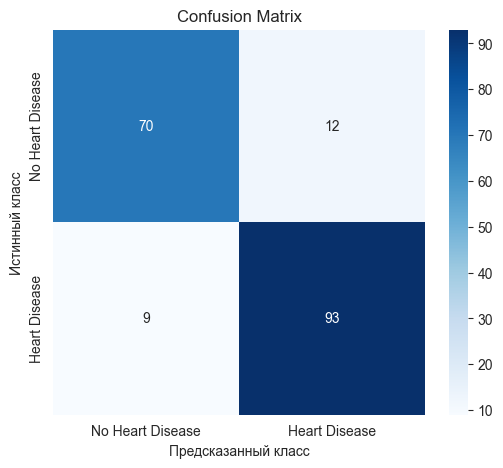

In [36]:
best_logistic = grid_search.best_estimator_
best_logistic.fit(X_train, y_train)
y_pred = best_logistic.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_logistic.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Улучшенный LogisticRegression:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall:   {recall:.4f}")

conf_matrix(y_pred, y_test)

Видим что модель не получила заметного прироста в метриках, но по матрице ошибок видно, что мы пропускаем меньше больных, жертвуя здоровыми.

### Ручная реализация

In [37]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Форма обработанных данных:", X_train_processed.shape)

Форма обработанных данных: (734, 15)


In [38]:
class MyLogisticRegression:
    def __init__(self, C=1.0, learning_rate=0.01, max_iter=1000, tol=1e-4, fit_intercept=True):
        self.C = C
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.fit_intercept = fit_intercept

    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        if self.fit_intercept:
            X = self._add_intercept(X)

        self.n_samples, self.n_features = X.shape
        self.weights = np.zeros(self.n_features)

        if self.fit_intercept:
            weight_indices = slice(1, None)
        else:
            weight_indices = slice(None)

        prev_loss = float('inf')

        for i in range(self.max_iter):
            z = np.dot(X, self.weights)
            y_pred = self._sigmoid(z)

            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

            log_loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            l2_reg = (1 / (2 * self.C)) * np.sum(self.weights[weight_indices] ** 2) / self.n_samples
            loss = log_loss + l2_reg

            gradient = np.dot(X.T, (y_pred - y)) / self.n_samples
            if self.fit_intercept:
                gradient[1:] += self.weights[1:] / (self.C * self.n_samples)
            else:
                gradient += self.weights / (self.C * self.n_samples)

            self.weights -= self.learning_rate * gradient

            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

        return self

    def predict_proba(self, X):
        X = np.array(X, dtype=np.float64)
        if self.fit_intercept:
            X = self._add_intercept(X)
        z = np.dot(X, self.weights)
        proba = self._sigmoid(z)
        return np.vstack((1 - proba, proba)).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

Запустим без улучшений и с улучшением. Так как алгорит lbfgs в рамках лабораторной работы реализовать не получится, мы будем работать с оставшимися параметрами.

Ручная реализация LogisticRegression:
Accuracy: 0.8424
ROC-AUC:  0.9234
F1-score: 0.8571
Recall:   0.8529


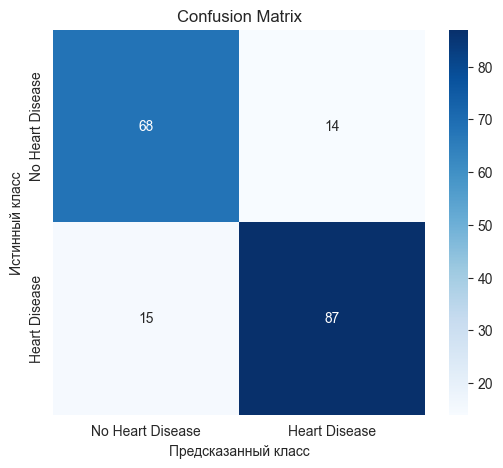


Улучшенная ручная LogisticRegression:
Accuracy: 0.8478
ROC-AUC:  0.9235
F1-score: 0.8641
Recall:   0.8725


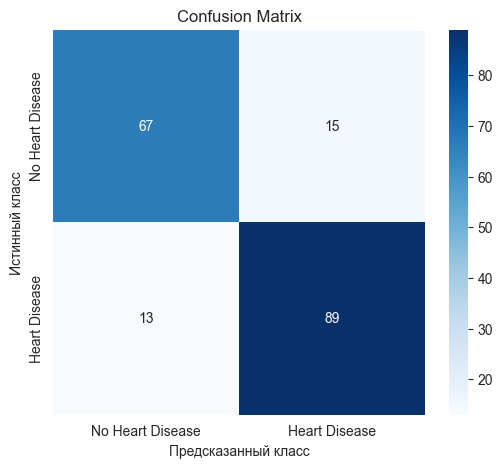

In [39]:
log_reg_my = MyLogisticRegression()
log_reg_my.fit(X_train_processed, y_train)

y_pred_my = log_reg_my.predict(X_test_processed)
y_proba_my = log_reg_my.predict_proba(X_test_processed)[:, 1]

acc_my = accuracy_score(y_test, y_pred_my)
roc_auc_my = roc_auc_score(y_test, y_proba_my)
f1_my = f1_score(y_test, y_pred_my)
recall_my = recall_score(y_test, y_pred_my)

print("Ручная реализация LogisticRegression:")
print(f"Accuracy: {acc_my:.4f}")
print(f"ROC-AUC:  {roc_auc_my:.4f}")
print(f"F1-score: {f1_my:.4f}")
print(f"Recall:   {recall_my:.4f}")

conf_matrix(y_pred_my, y_test)


log_reg_my_best = MyLogisticRegression(C=1.01, learning_rate=0.1, max_iter=1000)
log_reg_my_best.fit(X_train_processed, y_train)

y_pred_best = log_reg_my_best.predict(X_test_processed)
y_proba_best = log_reg_my_best.predict_proba(X_test_processed)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)
f1_best = f1_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)

print(f"\nУлучшенная ручная LogisticRegression:")
print(f"Accuracy: {acc_best:.4f}")
print(f"ROC-AUC:  {roc_auc_best:.4f}")
print(f"F1-score: {f1_best:.4f}")
print(f"Recall:   {recall_best:.4f}")

conf_matrix(y_pred_best, y_test)

# Регрессия

In [40]:
# df_reg = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
#                                   "kundanbedmutha/exam-score-prediction-dataset",
#                                   "Exam_Score_Prediction.csv")

df_reg = pd.read_csv("Exam_Score_Prediction.csv")

df_reg.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


Обработка категориальных признаков

In [41]:
df_reg['internet_access'] = df_reg['internet_access'].map({'yes': 1, 'no': 0})

sleep_map = {'poor': 0, 'average': 1, 'good': 2}
exam_diff_map = {'easy': 0, 'moderate': 1, 'hard': 2}
facil_diff_map = {'low': 0, 'medium': 1, 'high': 2}

df_reg['sleep_quality'] = df_reg['sleep_quality'].map(sleep_map)
df_reg['exam_difficulty'] = df_reg['exam_difficulty'].map(exam_diff_map)
df_reg['facility_rating'] = df_reg['facility_rating'].map(facil_diff_map)

print("NaN после маппинга:")
print(df_reg[['sleep_quality', 'exam_difficulty', 'facility_rating']].isnull().sum())

NaN после маппинга:
sleep_quality      0
exam_difficulty    0
facility_rating    0
dtype: int64


Как и в прошлой работе визуализируем целевую переменную

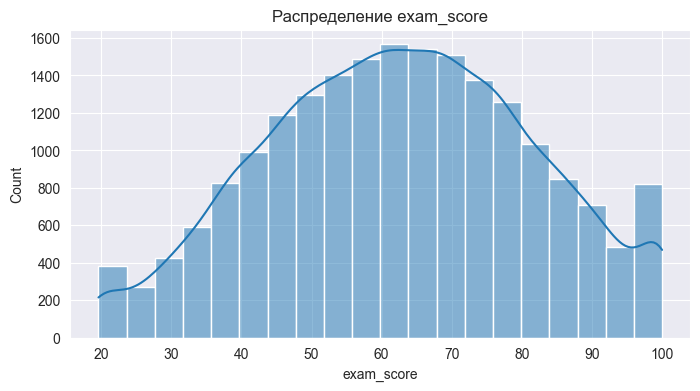

Статистика exam_score:
count    20000.000000
mean        62.513225
std         18.908491
min         19.599000
25%         48.800000
50%         62.600000
75%         76.300000
max        100.000000
Name: exam_score, dtype: float64


In [42]:
plt.figure(figsize=(8, 4))
sns.histplot(df_reg['exam_score'], kde=True, bins=20)
plt.title('Распределение exam_score')
plt.show()

print("Статистика exam_score:")
print(df_reg['exam_score'].describe())

Модель от sklearn

In [43]:
X = df_reg.drop('exam_score', axis=1)
y = df_reg['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
binary_features = ['internet_access']
ordinal_features = ['sleep_quality', 'exam_difficulty', 'facility_rating']
categorical_features = ['gender', 'course', 'study_method']

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ord', 'passthrough', ordinal_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

lin_reg_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', LinearRegression())
])

lin_reg_baseline.fit(X_train, y_train)
y_pred_baseline = lin_reg_baseline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae = mean_absolute_error(y_test, y_pred_baseline)
r2 = r2_score(y_test, y_pred_baseline)

print(f"Бейзлайн LinearRegression:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"R²:   {r2:.6f}")

Бейзлайн LinearRegression:
RMSE: 9.770809
MAE:  7.862338
R²:   0.733102


Подберем гиперпараметры. \
Будем подбирать параметр alpha (сила регуляризации) для Ridge регуляризации. Lasso не имеет смысла, потому что признаков не так много и все они имеют смысл.

In [44]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

lin_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', Ridge())
])

param_grid = {
    'regressor__alpha': np.logspace(-3, 3, 50)
}

grid_reg = GridSearchCV(
    lin_reg,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_reg.fit(X_train, y_train)

print("Лучшие параметры:", grid_reg.best_params_)
print("Лучший RMSE (CV):", -grid_reg.best_score_)

Лучшие параметры: {'regressor__alpha': np.float64(2.6826957952797246)}
Лучший RMSE (CV): 9.803133557436984


In [45]:
best_model = grid_reg.best_estimator_
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\nУлучшенная модель (Ridge):")
print(f"RMSE: {rmse_best:.6f}")
print(f"MAE:  {mae_best:.6f}")
print(f"R²:   {r2_best:.6f}")


Улучшенная модель (Ridge):
RMSE: 9.770690
MAE:  7.862343
R²:   0.733108


После подбора параметра регуляризации alpha (лучшее значение: 2.68) модель Ridge показала незначительное улучшение качества. Это говорит о том, что линейная модель почти оптимальна для данной задачи, а регуляризация лишь слегка снижает дисперсию предсказаний

### Ручная реализация

In [46]:
import numpy as np

class LinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        if self.fit_intercept:
            X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

        XtX = np.dot(X.T, X)
        Xty = np.dot(X.T, y)

        self.weights = np.linalg.solve(XtX, Xty)
        return self

    def predict(self, X):
        X = np.array(X, dtype=np.float64)
        if self.fit_intercept:
            X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return np.dot(X, self.weights)

In [47]:
X_train_processed = preprocessor_reg.fit_transform(X_train)
X_test_processed = preprocessor_reg.transform(X_test)

In [48]:
my_lin_reg = LinearRegression(fit_intercept=True)
my_lin_reg.fit(X_train_processed, y_train)
y_pred_my = my_lin_reg.predict(X_test_processed)

rmse_my = np.sqrt(mean_squared_error(y_test, y_pred_my))
mae_my = mean_absolute_error(y_test, y_pred_my)
r2_my = r2_score(y_test, y_pred_my)

print("Ручная LinearRegression (без регуляризации):")
print(f"RMSE: {rmse_my:.6f}")
print(f"MAE:  {mae_my:.6f}")
print(f"R²:   {r2_my:.6f}")

Ручная LinearRegression (без регуляризации):
RMSE: 9.770809
MAE:  7.862338
R²:   0.733102


In [49]:
class RidgeRegression:
    def __init__(self, alpha=1.0, fit_intercept=True):
        self.alpha = alpha
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        if self.fit_intercept:
            X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

        n_features = X.shape[1]
        reg_matrix = np.eye(n_features)
        if self.fit_intercept:
            reg_matrix[0, 0] = 0

        XtX = np.dot(X.T, X)
        Xty = np.dot(X.T, y)

        A = XtX + self.alpha * reg_matrix
        self.weights = np.linalg.solve(A, Xty)
        return self

    def predict(self, X):
        X = np.array(X, dtype=np.float64)
        if self.fit_intercept:
            X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return np.dot(X, self.weights)

In [50]:
best_alpha = grid_reg.best_params_['regressor__alpha']

my_ridge_reg = RidgeRegression(alpha=best_alpha, fit_intercept=True)
my_ridge_reg.fit(X_train_processed, y_train)
y_pred_ridge_my = my_ridge_reg.predict(X_test_processed)

rmse_ridge_my = np.sqrt(mean_squared_error(y_test, y_pred_ridge_my))
mae_ridge_my = mean_absolute_error(y_test, y_pred_ridge_my)
r2_ridge_my = r2_score(y_test, y_pred_ridge_my)

print(f"\nРучная RidgeRegression (alpha={best_alpha:.4f}):")
print(f"RMSE: {rmse_ridge_my:.6f}")
print(f"MAE:  {mae_ridge_my:.6f}")
print(f"R²:   {r2_ridge_my:.6f}")


Ручная RidgeRegression (alpha=2.6827):
RMSE: 9.770690
MAE:  7.862343
R²:   0.733108


Как видим ручная реализация показала те же результаты, что и модель от sklearn.